# ML-Based Diet Planner with Clustering
This notebook calculates calorie requirements, clusters foods by nutrition, and recommends meals based on user's goal.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

### Load Nutrition Dataset

In [5]:
data = pd.read_csv('nutrition_dataset_github.csv')
data.head()

,Name,Serving (grams),Calories,Fat,Protein,Carbohydrates,Fiber
0,apple_pie,100.0,265,12.50,2.40,37.10,1.6
1,baby_back_ribs,40.0,110,7.50,8.00,2.20,0.1
2,baklava,76.0,306,20.00,5.50,29.00,1.8
3,beef_carpaccio,78.0,181,13.00,13.00,2.00,0.2
4,beef_tartare,100.0,210,14.56,17.78,0.63,0.1


### User Profile & Calorie Calculation

In [8]:
user_profile = {
    "age": 25,
    "gender": "female",
    "height_cm": 170,
    "weight_kg": 70,
    "activity_level": "moderate",
    "goal": "gain"
}

def calculate_calories(profile):
    if profile["gender"] == "male":
        bmr = 10 * profile["weight_kg"] + 6.25 * profile["height_cm"] - 5 * profile["age"] + 5
    else:
        bmr = 10 * profile["weight_kg"] + 6.25 * profile["height_cm"] - 5 * profile["age"] - 161

    activity_factor = {
        "sedentary": 1.2,
        "light": 1.375,
        "moderate": 1.55,
        "active": 1.725
    }
    daily_calories = bmr * activity_factor[profile["activity_level"]]

    if profile["goal"] == "lose":
        daily_calories -= 500
    elif profile["goal"] == "gain":
        daily_calories += 500

    return int(daily_calories)

required_calories = calculate_calories(user_profile)
print("Daily Calorie Requirement:", required_calories, "kcal")

Daily Calorie Requirement: 2288 kcal


### Nutrition Clustering with KMeans

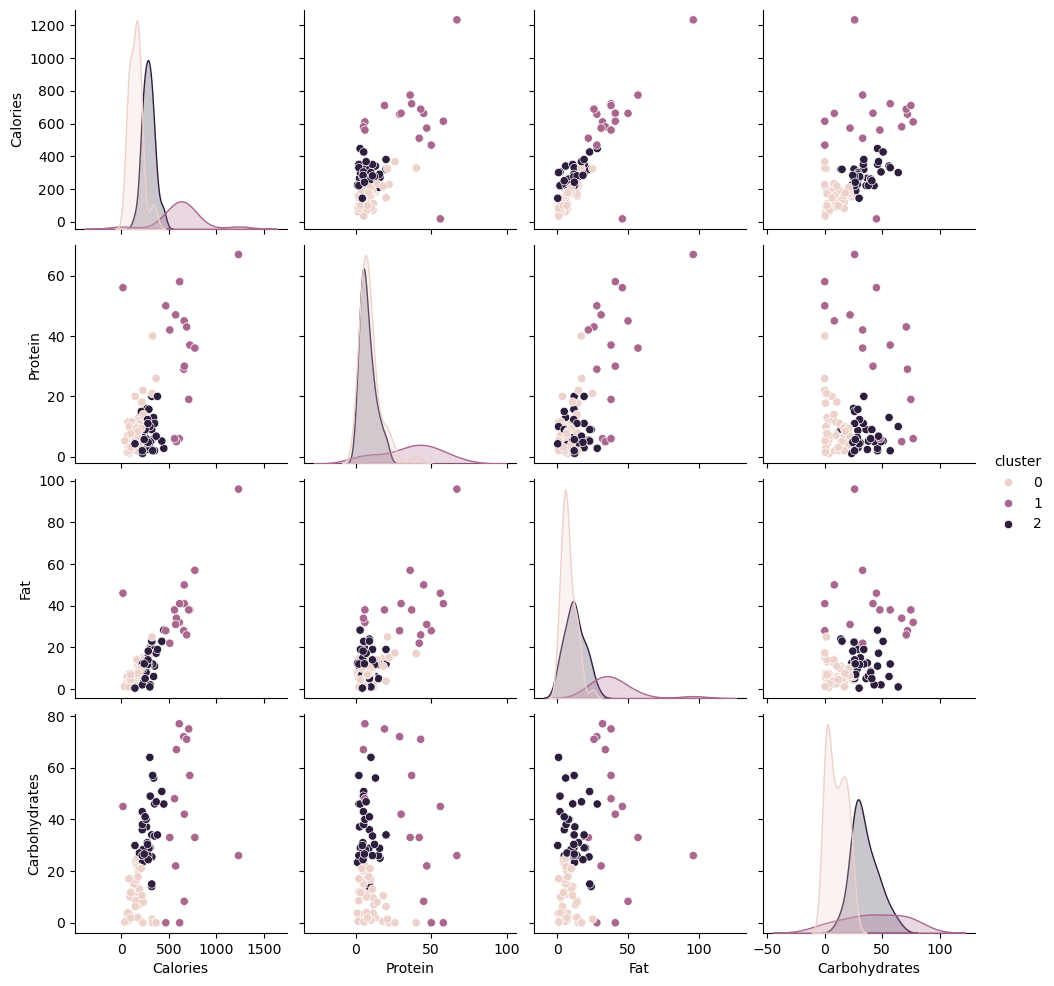

In [11]:
features = data[["Calories", "Protein", "Fat", "Carbohydrates"]]
scaled = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled)

sns.pairplot(data, hue='cluster', vars=["Calories", "Protein", "Fat", "Carbohydrates"])
plt.show()

### Analyze Clusters

In [14]:
data.groupby('cluster')[['Calories', 'Protein', 'Fat', 'Carbohydrates']].mean()

,Calories,Protein,Fat,Carbohydrates
cluster,,,,
0,151.020833,9.162500,7.888125,10.116042
1,627.500000,36.000000,40.375000,42.268750
2,285.378378,7.676486,12.391622,34.764865


### Goal-Based Cluster Selection & Meal Recommendation

In [23]:
def choose_cluster_by_goal(goal):
    if goal == "lose":
        return [0]
    elif goal == "gain":
        return [1, 2]
    elif goal == "maintain":
        return [0, 1]
    else:
        return [0, 1, 2]

def recommend_meals(data, required_calories, user_goal):
    selected_clusters = choose_cluster_by_goal(user_goal)
    meals = data[(data['cluster'].isin(selected_clusters)) & (data['Calories'] < required_calories * 0.4)]
    if meals.empty:
        return data.sample(3)[['Name', 'Calories', 'Protein', 'Fat', 'Carbohydrates']]
    return meals.sample(min(3, len(meals)))[['Name', 'Calories', 'Protein', 'Fat', 'Carbohydrates']]

recommended = recommend_meals(data, required_calories, user_profile['goal'])
print(recommended)

             Name  Calories  Protein   Fat  Carbohydrates
8   bread_pudding       153     5.27  4.74          23.26
84        risotto       174     6.87  6.43          21.69
69        oysters        68     7.05  2.46           3.91
